<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Finance (2nd ed.)

**Mastering Data-Driven Finance**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

<img src="http://hilpisch.com/images/py4fi_2nd_shadow.png" width="300px" align="left">

# Trading Strategies (a)

## Simple Moving Averages

### Data Import

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [3]:
raw = pd.read_csv('../../source/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
AAPL.O    2138 non-null float64
MSFT.O    2138 non-null float64
INTC.O    2138 non-null float64
AMZN.O    2138 non-null float64
GS.N      2138 non-null float64
SPY       2138 non-null float64
.SPX      2138 non-null float64
.VIX      2138 non-null float64
EUR=      2216 non-null float64
XAU=      2211 non-null float64
GDX       2138 non-null float64
GLD       2138 non-null float64
dtypes: float64(12)
memory usage: 225.1 KB


In [5]:
symbol = 'AAPL.O'

In [6]:
data = (
    pd.DataFrame(raw[symbol])
    .dropna()
)

### Trading Strategy

In [7]:
SMA1 = 42  
SMA2 = 252  

In [8]:
data['SMA1'] = data[symbol].rolling(SMA1).mean()  
data['SMA2'] = data[symbol].rolling(SMA2).mean()  

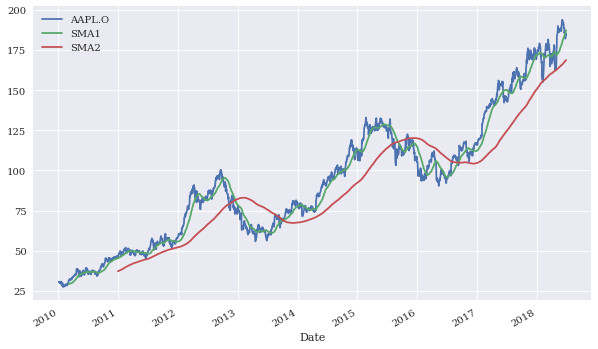

In [9]:
data.plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_plot_01.png')

In [10]:
data.dropna(inplace=True)

In [11]:
data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)  

In [12]:
data.tail()

,AAPL.O,SMA1,SMA2,Position
Date,,,,
2018-06-25,182.17,185.606190,168.265556,1
2018-06-26,184.43,186.087381,168.418770,1
2018-06-27,184.16,186.607381,168.579206,1
2018-06-28,185.50,187.089286,168.736627,1
2018-06-29,185.11,187.470476,168.901032,1


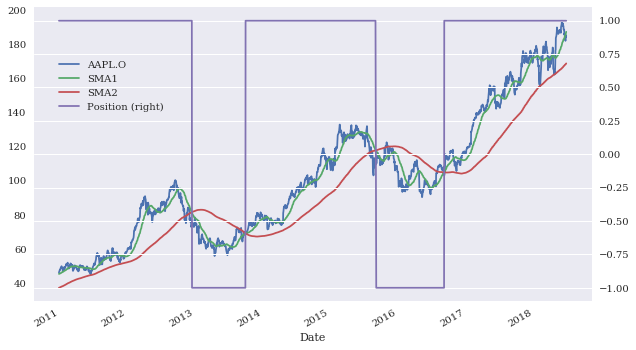

In [13]:
ax = data.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));
# plt.savefig('../../images/ch15/strat_plot_02.png')

### Vectorized Backtesting

In [14]:
data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))  

In [15]:
data['Strategy'] = data['Position'].shift(1) * data['Returns']  

In [16]:
data.round(4).head()

,AAPL.O,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
2010-12-31,46.0800,45.2810,37.1207,1,NaN,NaN
2011-01-03,47.0814,45.3497,37.1862,1,0.0215,0.0215
2011-01-04,47.3271,45.4126,37.2525,1,0.0052,0.0052
2011-01-05,47.7142,45.4661,37.3223,1,0.0081,0.0081
2011-01-06,47.6757,45.5226,37.3921,1,-0.0008,-0.0008


In [17]:
data.dropna(inplace=True)

In [18]:
np.exp(data[['Returns', 'Strategy']].sum())  

Returns     4.017148
Strategy    5.811299
dtype: float64

In [19]:
data[['Returns', 'Strategy']].std() * 252 ** 0.5  

Returns     0.250571
Strategy    0.250407
dtype: float64

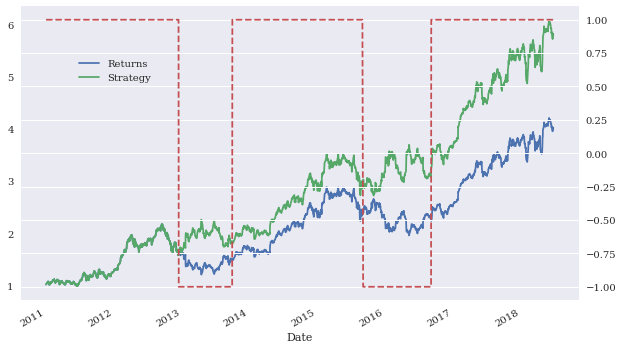

In [20]:
ax = data[['Returns', 'Strategy']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6))
data['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));
# plt.savefig('../../images/ch15/strat_plot_03.png');

### Optimization

In [21]:
from itertools import product

In [22]:
sma1 = range(20, 61, 4)  
sma2 = range(180, 281, 10)  

In [23]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):  
    data = pd.DataFrame(raw[symbol])
    data.dropna(inplace=True)
    data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
    data['SMA1'] = data[symbol].rolling(SMA1).mean()
    data['SMA2'] = data[symbol].rolling(SMA2).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns', 'Strategy']].sum())
    results = results.append(pd.DataFrame(
                {'SMA1': SMA1, 'SMA2': SMA2,
                 'MARKET': perf['Returns'],
                 'STRATEGY': perf['Strategy'],
                 'OUT': perf['Strategy'] - perf['Returns']},
                 index=[0]), ignore_index=True)  

In [24]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 5 columns):
SMA1        121 non-null int64
SMA2        121 non-null int64
MARKET      121 non-null float64
STRATEGY    121 non-null float64
OUT         121 non-null float64
dtypes: float64(3), int64(2)
memory usage: 4.8 KB


In [25]:
results.sort_values('OUT', ascending=False).head(7)

,SMA1,SMA2,MARKET,STRATEGY,OUT
56,40,190,4.650342,7.175173,2.524831
39,32,240,4.045619,6.558690,2.513071
59,40,220,4.220272,6.544266,2.323994
46,36,200,4.074753,6.389627,2.314874
55,40,180,4.574979,6.857989,2.283010
70,44,220,4.220272,6.469843,2.249571
101,56,200,4.074753,6.319524,2.244772


## Random Walk Hypothesis

In [26]:
symbol = '.SPX'

In [27]:
data = pd.DataFrame(raw[symbol])

In [28]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)  
    data[col] = data[symbol].shift(lag)  
    cols.append(col)  

In [29]:
data.head(7)

,.SPX,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,1132.99,NaN,NaN,NaN,NaN,NaN
2010-01-05,1136.52,1132.99,NaN,NaN,NaN,NaN
2010-01-06,1137.14,1136.52,1132.99,NaN,NaN,NaN
2010-01-07,1141.69,1137.14,1136.52,1132.99,NaN,NaN
2010-01-08,1144.98,1141.69,1137.14,1136.52,1132.99,NaN
2010-01-11,1146.98,1144.98,1141.69,1137.14,1136.52,1132.99


In [30]:
data.dropna(inplace=True)

In [31]:
reg = np.linalg.lstsq(data[cols], data[symbol], rcond=-1)[0]

In [32]:
reg.round(3)

array([0.966, 0.005, 0.025, 0.   , 0.003])

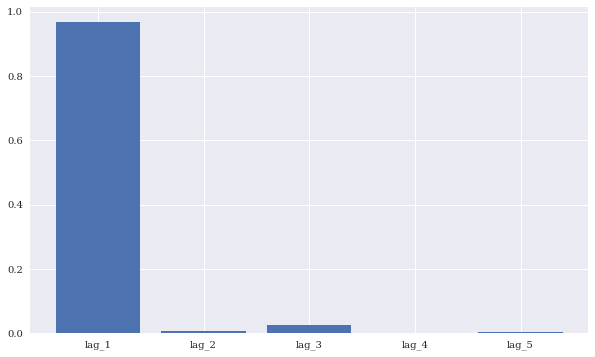

In [33]:
plt.figure(figsize=(10, 6))
plt.bar(cols, reg);
# plt.savefig('../../images/ch15/strat_plot_04.png');

In [34]:
data['Prediction'] = np.dot(data[cols], reg)

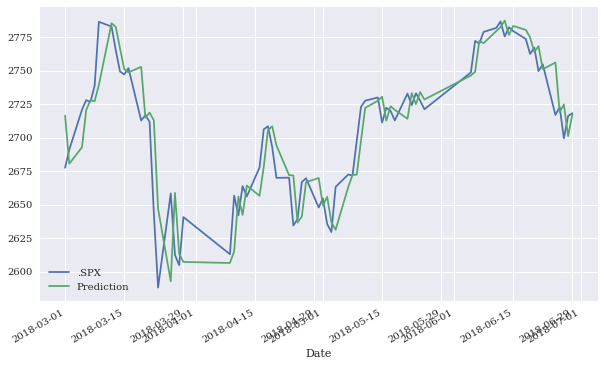

In [35]:
data[[symbol, 'Prediction']].iloc[-75:].plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_plot_05.png');

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>